# COMP0005 - GROUP COURSEWORK 2023-24
# Gesture Recognition via Convex Hull 

Use the cell below for all python code needed to realise the **Jarvis march algorithm** (including auxiliary data structures and functions needed by this algorithm - if any). The `jarvismarch()` function itself should take as input parameter a list of 2D points (`inputSet`), and return the subset of such points (`outputSet`) that lie on the convex hull.

In [1]:
test_points = [
    (30, 60),
    (0, 30),
    (50, 40),
    (15, 25),
    (70, 30),
    (55, 20),
    (50, 10),
    (20, 0),
]

In [1]:
import math

def jarvis_march(input_set: list[tuple[int, int]]) -> list[tuple[int, int]]:
    '''
    Returns the list of points that lie on the convex hull (jarvis march algorithm)
            Parameters:
                    inputSet (list): a list of 2D points

            Returns:
                    outputSet (list): a list of 2D points
    '''

    # ADD YOUR CODE HERE

    return output_set

Use the cell below for all python code needed to realise the **Graham scan** algorithm (including auxiliary data structures and functions needed by this algorithm - if any). The `grahamscan()` function itself should take as input parameter a list of 2D points (`inputSet`), and return the subset of such points that lie on the convex hull (`outputSet`).

In [23]:
import math

def is_counter_clockwise(p1: tuple[int, int], p2: tuple[int, int], p3: tuple[int, int]) -> bool:
    area = (p2[0] - p1[0]) * (p3[1] - p1[1]) - (p2[1] - p1[1]) * (p3[0] - p1[0])
    return area > 0

def get_min_y_index(input_set: list[tuple[int, int]]) -> int:
    min_y = math.inf
    min_y_index = 0
    for i in range(len(input_set)):
        if input_set[i][1] < min_y:
            min_y = input_set[i][1]
            min_y_index = i
    return min_y_index

def sort_by_polar_angle(p0: tuple[int, int], input_set: list[tuple[int, int]]) -> list[tuple[int, int]]:
    input_set.sort(key=lambda p: math.atan2(p[1] - p0[1], p[0] - p0[0]))
    return input_set

def graham_scan(input_set: list[tuple[int, int]]) -> list[tuple[int, int]]:
    """
    Returns the list of points that lie on the convex hull (graham scan algorithm)
            Parameters:
                    input_set (list): a list of 2D points

            Returns:
                    output_set (list): a list of 2D points
    """
    stack = []
    min_y_index = get_min_y_index(input_set)
    input_set[0], input_set[min_y_index] = input_set[min_y_index], input_set[0]
    p0 = input_set[0]
    sort_by_polar_angle(p0, input_set)
    print(input_set)
    stack.append(p0)
    stack.append(input_set[1])
    for i in range(2, len(input_set)):
        while len(stack) > 1 and not is_counter_clockwise(stack[-2], stack[-1], input_set[i]):
            stack.pop()
        stack.append(input_set[i])
    return stack

In [26]:
import matplotlib.pyplot as plt

def plot_points(input_set: list[tuple[int, int]], output_set: list[tuple[int, int]]) -> None:
    x = [i[0] for i in input_set]
    y = [i[1] for i in input_set]
    plt.scatter(x, y)
    x = [i[0] for i in output_set]
    y = [i[1] for i in output_set]
    # close the loop
    x.append(output_set[0][0])
    y.append(output_set[0][1])
    plt.plot(x, y)
    plt.show()

[(20, 0), (50, 10), (55, 20), (70, 30), (50, 40), (30, 60), (15, 25), (0, 30)]


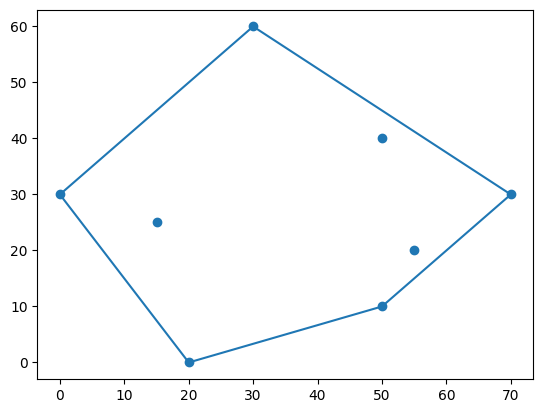

In [27]:
# test graham scan
output_set = graham_scan(test_points)
plot_points(test_points, output_set)

Use the cell below for all python code needed to realise the **Chen's** algorithm (including auxiliary data structures and functions needed by this algorithm - if any). The `chen()` function itself should take as input parameter a list of 2D points (`inputSet`), and return the subset of such points that lie on the convex hull (`outputSet`).

In [3]:
def chen(input_set: list[tuple[int, int]]) -> list[tuple[int, int]]:
    '''
    Returns the list of points that lie on the convex hull (chen's algorithm)
            Parameters:
                    inputSet (list): a list of 2D points

            Returns:
                    outputSet (list): a list of 2D points
    '''

    # ADD YOUR CODE HERE
    
    return output_set

Use the cell below to implement the **synthetic data generator** needed by your experimental framework (including any auxiliary data structures and functions you might need - be mindful of code readability and reusability).

In [4]:
import random

class TestDataGenerator():
    """
    A class to represent a synthetic data generator.

    ...

    Attributes
    ----------
    
    [to be defined as part of the coursework]

    Methods
    -------
    
    [to be defined as part of the coursework]

    """
        
    #ADD YOUR CODE HERE
    
    def __init__():
        pass


Use the cell below to implement the requested **experimental framework** API.

In [5]:
import timeit
import matplotlib

class ExperimentalFramework():
    """
    A class to represent an experimental framework.

    ...

    Attributes
    ----------
    
    [to be defined as part of the coursework]

    Methods
    -------
    
    [to be defined as part of the coursework]

    """
        
    #ADD YOUR CODE HERE
    
    def __init__():
        pass

Use the cell below to illustrate the python code you used to **fully evaluate** the three convex hull algortihms under considerations. The code below should illustrate, for example, how you made used of the **TestDataGenerator** class to generate test data of various size and properties; how you instatiated the **ExperimentalFramework** class to  evaluate each algorithm using such data, collect information about their execution time, plots results, etc. Any results you illustrate in the companion PDF report should have been generated using the code below.

In [6]:
# ADD YOUR TEST CODE HERE 



